In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv('Dataset/Microsoft_Stock.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()

data = data.ffill()

In [6]:
scaler = MinMaxScaler()
data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [7]:
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][3]  # Predicting the "Close" price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data[['Open', 'High', 'Low', 'Close', 'Volume']].values, seq_length)

In [8]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
mse_loss = nn.MSELoss()

class NovelLossFunction(nn.Module):
    def __init__(self):
        super(NovelLossFunction, self).__init__()

    def forward(self, y_pred, y_true):
        n = y_true.shape[0]
        weights = torch.arange(1, n+1, dtype=torch.float32) / n
        return torch.mean(weights * torch.abs(y_true - y_pred))

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [12]:
def train_and_evaluate(model, loss_fn, optimizer, train_loader, test_loader, epochs=100):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0
        y_true, y_pred_list = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch).squeeze()
                loss = loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                y_true.extend(y_batch.tolist())
                y_pred_list.extend(y_pred.tolist())

        test_losses.append(test_loss / len(test_loader))
        mae = mean_absolute_error(y_true, y_pred_list)
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, MAE: {mae:.4f}")
    return y_true, y_pred_list, train_losses, test_losses

In [13]:
results = {}
loss_curves = {}

In [14]:
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Training with MSE Loss Function")
y_true_mse, y_pred_mse, train_losses_mse, test_losses_mse = train_and_evaluate(model, mse_loss, optimizer, train_loader, test_loader)
results['MSE Loss Function'] = (y_true_mse, y_pred_mse)
loss_curves['MSE Loss Function'] = (train_losses_mse, test_losses_mse)

Training with MSE Loss Function
Epoch 1, Train Loss: 0.0182, Test Loss: 0.0025, MAE: 0.0428
Epoch 2, Train Loss: 0.0010, Test Loss: 0.0055, MAE: 0.0646
Epoch 3, Train Loss: 0.0002, Test Loss: 0.0010, MAE: 0.0242
Epoch 4, Train Loss: 0.0001, Test Loss: 0.0016, MAE: 0.0326
Epoch 5, Train Loss: 0.0001, Test Loss: 0.0026, MAE: 0.0430
Epoch 6, Train Loss: 0.0001, Test Loss: 0.0018, MAE: 0.0340
Epoch 7, Train Loss: 0.0001, Test Loss: 0.0031, MAE: 0.0476
Epoch 8, Train Loss: 0.0001, Test Loss: 0.0027, MAE: 0.0440
Epoch 9, Train Loss: 0.0001, Test Loss: 0.0024, MAE: 0.0409
Epoch 10, Train Loss: 0.0001, Test Loss: 0.0018, MAE: 0.0349
Epoch 11, Train Loss: 0.0001, Test Loss: 0.0015, MAE: 0.0310
Epoch 12, Train Loss: 0.0001, Test Loss: 0.0014, MAE: 0.0304
Epoch 13, Train Loss: 0.0001, Test Loss: 0.0028, MAE: 0.0459
Epoch 14, Train Loss: 0.0001, Test Loss: 0.0013, MAE: 0.0291
Epoch 15, Train Loss: 0.0001, Test Loss: 0.0014, MAE: 0.0307
Epoch 16, Train Loss: 0.0001, Test Loss: 0.0016, MAE: 0.0325
E

In [15]:
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("\nTraining with Novel Loss Function")
y_true_novel, y_pred_novel, train_losses_novel, test_losses_novel = train_and_evaluate(model, NovelLossFunction(), optimizer, train_loader, test_loader)
results['Novel Loss Function'] = (y_true_novel, y_pred_novel)
loss_curves['Novel Loss Function'] = (train_losses_novel, test_losses_novel)


Training with Novel Loss Function
Epoch 1, Train Loss: 0.0409, Test Loss: 0.0743, MAE: 0.1343
Epoch 2, Train Loss: 0.0063, Test Loss: 0.0152, MAE: 0.0287
Epoch 3, Train Loss: 0.0034, Test Loss: 0.0209, MAE: 0.0388
Epoch 4, Train Loss: 0.0034, Test Loss: 0.0201, MAE: 0.0375
Epoch 5, Train Loss: 0.0032, Test Loss: 0.0192, MAE: 0.0359
Epoch 6, Train Loss: 0.0036, Test Loss: 0.0158, MAE: 0.0293
Epoch 7, Train Loss: 0.0032, Test Loss: 0.0247, MAE: 0.0465
Epoch 8, Train Loss: 0.0032, Test Loss: 0.0177, MAE: 0.0333
Epoch 9, Train Loss: 0.0030, Test Loss: 0.0208, MAE: 0.0394
Epoch 10, Train Loss: 0.0032, Test Loss: 0.0174, MAE: 0.0329
Epoch 11, Train Loss: 0.0030, Test Loss: 0.0193, MAE: 0.0365
Epoch 12, Train Loss: 0.0030, Test Loss: 0.0168, MAE: 0.0319
Epoch 13, Train Loss: 0.0036, Test Loss: 0.0139, MAE: 0.0264
Epoch 14, Train Loss: 0.0035, Test Loss: 0.0142, MAE: 0.0271
Epoch 15, Train Loss: 0.0030, Test Loss: 0.0133, MAE: 0.0253
Epoch 16, Train Loss: 0.0030, Test Loss: 0.0135, MAE: 0.025

In [16]:
class mae_loss(nn.Module):
    def __init__(self):
        super(mae_loss, self).__init__()

    def forward(self, y_pred, y_true):
        n = y_true.shape[0]
        return torch.mean(torch.abs(y_true - y_pred))

In [17]:
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Training with MAE Loss Function")
y_true_mae, y_pred_mae, train_losses_mae, test_losses_mae = train_and_evaluate(model, mae_loss(), optimizer, train_loader, test_loader)
results['MAE Loss Function'] = (y_true_mae, y_pred_mae)
loss_curves['MAE Loss Function'] = (train_losses_mae, test_losses_mae)

Training with MAE Loss Function
Epoch 1, Train Loss: 0.1399, Test Loss: 0.2590, MAE: 0.2550
Epoch 2, Train Loss: 0.0221, Test Loss: 0.0486, MAE: 0.0476
Epoch 3, Train Loss: 0.0092, Test Loss: 0.0274, MAE: 0.0274
Epoch 4, Train Loss: 0.0080, Test Loss: 0.0243, MAE: 0.0242
Epoch 5, Train Loss: 0.0066, Test Loss: 0.0286, MAE: 0.0279
Epoch 6, Train Loss: 0.0063, Test Loss: 0.0476, MAE: 0.0462
Epoch 7, Train Loss: 0.0064, Test Loss: 0.0308, MAE: 0.0300
Epoch 8, Train Loss: 0.0057, Test Loss: 0.0346, MAE: 0.0336
Epoch 9, Train Loss: 0.0060, Test Loss: 0.0339, MAE: 0.0330
Epoch 10, Train Loss: 0.0058, Test Loss: 0.0278, MAE: 0.0273
Epoch 11, Train Loss: 0.0059, Test Loss: 0.0368, MAE: 0.0359
Epoch 12, Train Loss: 0.0059, Test Loss: 0.0296, MAE: 0.0290
Epoch 13, Train Loss: 0.0057, Test Loss: 0.0291, MAE: 0.0285
Epoch 14, Train Loss: 0.0063, Test Loss: 0.0207, MAE: 0.0210
Epoch 15, Train Loss: 0.0063, Test Loss: 0.0241, MAE: 0.0240
Epoch 16, Train Loss: 0.0055, Test Loss: 0.0342, MAE: 0.0334
E

In [18]:
class HuberLossFunction(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLossFunction, self).__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        error = y_true - y_pred
        is_small_error = torch.abs(error) <= self.delta
        small_error_loss = 0.5 * torch.pow(error, 2)
        large_error_loss = self.delta * (torch.abs(error) - 0.5 * self.delta)
        return torch.mean(torch.where(is_small_error, small_error_loss, large_error_loss))


In [19]:
# Training with Huber Loss Function
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
huber_loss = HuberLossFunction(delta=1.0)
print("\nTraining with Huber Loss Function")
y_true_huber, y_pred_huber, train_losses_huber, test_losses_huber = train_and_evaluate(
    model, huber_loss, optimizer, train_loader, test_loader
)
results['Huber Loss Function'] = (y_true_huber, y_pred_huber)
loss_curves['Huber Loss Function'] = (train_losses_huber, test_losses_huber)


Training with Huber Loss Function
Epoch 1, Train Loss: 0.0054, Test Loss: 0.0146, MAE: 0.1602
Epoch 2, Train Loss: 0.0002, Test Loss: 0.0006, MAE: 0.0270
Epoch 3, Train Loss: 0.0000, Test Loss: 0.0013, MAE: 0.0430
Epoch 4, Train Loss: 0.0000, Test Loss: 0.0013, MAE: 0.0410
Epoch 5, Train Loss: 0.0000, Test Loss: 0.0016, MAE: 0.0470
Epoch 6, Train Loss: 0.0000, Test Loss: 0.0013, MAE: 0.0423
Epoch 7, Train Loss: 0.0000, Test Loss: 0.0011, MAE: 0.0373
Epoch 8, Train Loss: 0.0000, Test Loss: 0.0011, MAE: 0.0387
Epoch 9, Train Loss: 0.0000, Test Loss: 0.0009, MAE: 0.0332
Epoch 10, Train Loss: 0.0000, Test Loss: 0.0011, MAE: 0.0378
Epoch 11, Train Loss: 0.0000, Test Loss: 0.0011, MAE: 0.0389
Epoch 12, Train Loss: 0.0000, Test Loss: 0.0013, MAE: 0.0428
Epoch 13, Train Loss: 0.0000, Test Loss: 0.0012, MAE: 0.0410
Epoch 14, Train Loss: 0.0000, Test Loss: 0.0009, MAE: 0.0347
Epoch 15, Train Loss: 0.0000, Test Loss: 0.0009, MAE: 0.0356
Epoch 16, Train Loss: 0.0000, Test Loss: 0.0010, MAE: 0.036

In [20]:
for loss_name, (y_true, y_pred) in results.items():
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = (1 - mae) * 100
    print(f"Accuracy of the model trained with {loss_name}: {accuracy:.2f}%")

Accuracy of the model trained with MSE Loss Function: 98.09%
Accuracy of the model trained with Novel Loss Function: 98.12%
Accuracy of the model trained with MAE Loss Function: 98.26%
Accuracy of the model trained with Huber Loss Function: 98.25%


In [21]:
from sklearn.metrics import r2_score

for loss_name, (y_true, y_pred) in results.items():
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Performance of the model trained with {loss_name}:")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - R^2 Score: {r2:.4f}")

Performance of the model trained with MSE Loss Function:
  - Mean Absolute Error (MAE): 0.0191
  - R^2 Score: 0.9603
Performance of the model trained with Novel Loss Function:
  - Mean Absolute Error (MAE): 0.0188
  - R^2 Score: 0.9618
Performance of the model trained with MAE Loss Function:
  - Mean Absolute Error (MAE): 0.0174
  - R^2 Score: 0.9657
Performance of the model trained with Huber Loss Function:
  - Mean Absolute Error (MAE): 0.0175
  - R^2 Score: 0.9651


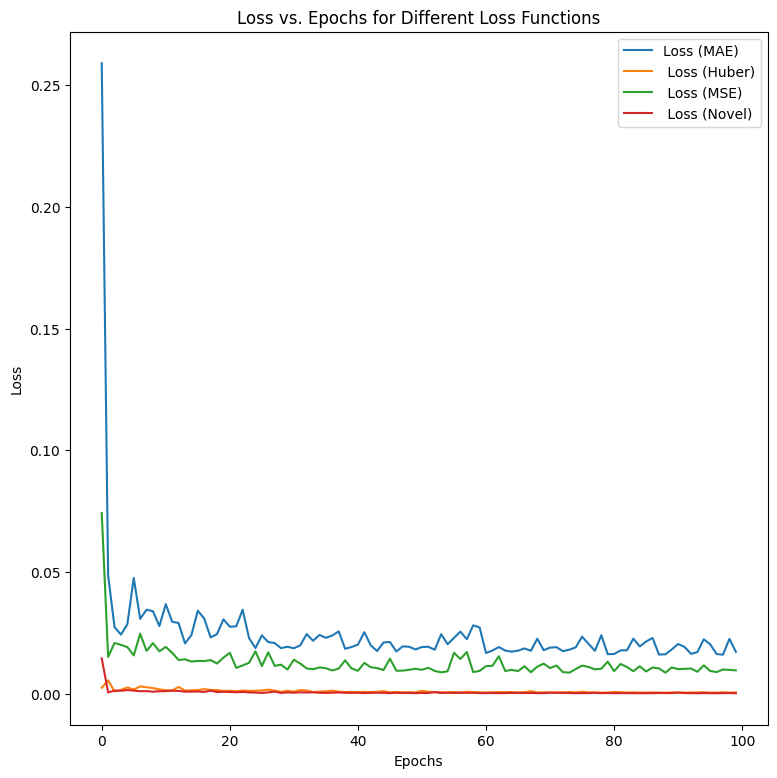

In [28]:

plt.figure(figsize=(9, 9))
plt.plot(test_losses_mae,label = 'Loss (MAE)')
plt.plot(test_losses_mse, label=' Loss (Huber)')
plt.plot(test_losses_novel, label=' Loss (MSE)')
plt.plot(test_losses_huber, label=' Loss (Novel)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs for Different Loss Functions')
plt.legend()
plt.show()



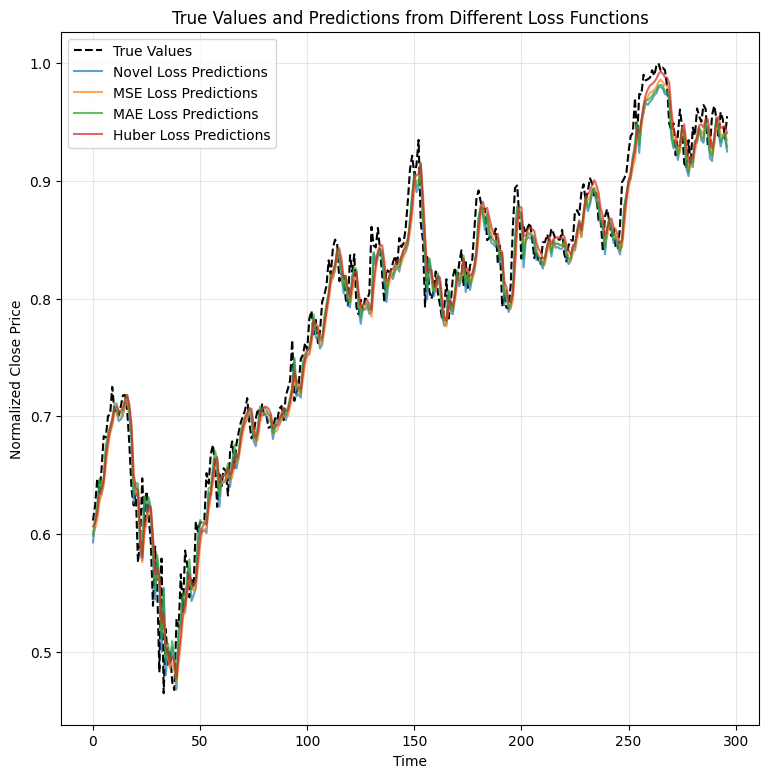

In [29]:
# Plot predictions from all models along with the true values
plt.figure(figsize=(9, 9))

plt.plot(y_true_mse, label='True Values', color='black', linestyle='--', linewidth=1.5)
plt.plot(y_pred_novel, label='Novel Loss Predictions', alpha=0.7)
plt.plot(y_pred_mse, label='MSE Loss Predictions', alpha=0.7)
plt.plot(y_pred_mae, label='MAE Loss Predictions', alpha=0.7)
plt.plot(y_pred_huber, label='Huber Loss Predictions', alpha=0.7)

plt.title('True Values and Predictions from Different Loss Functions')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
